# Step by step analysis of Ant Colony Simulations

### Ant Colony Evaluation through Simulations

In the last half of the century there were created techniques to analyze behavior through random repetition.
These techniques are known as Monte Carlo Methods, this is name came from the old name of the casino game Roullete.
Papers were written showing the power of simulating an experiment over thousand and thousand times.

So with this idea, I created an script that runs the Ant Colony System to solve the graph of 14 Cities in Burma.
And based on this script and the Analysis of the results I also created an Step by Step Analysis to later confirm
the results found to this instance in other graphs.

Ant Colony System is based on 6 Parameters: Alpha, Beta, Rho, Elite, Ant and Limit

1) Alpha is the parameter related to the pheromone amount in an edge
2) Beta is the parameter related to the shortness of an edge
3) Rho is the parameter related to the pheromone decrease rate
4) Elite is the parameter related to the pheromone boost to the best ant of one generation
5) Ant is the parameter related to the amount of Ants per generation
6) Limit is the parameter related to the number of generations the algorithm is going to run

To each of this parameter were chosen a sample of values to iterate over, and since the algorithm relies on randomness
every group of the parameters were repeated 30 times, this way ensuring that a reliable solution may come appear.

- Initialize with the first value
- For 30 Times do
  - Run ACS with chosen parameters
  - Save sequence and results
  
- Change one parameter
- Repeat 2 until all parameters are tested

This Process generated a dataset with over a Million data points and with this Dataset I going to go step by step in finding the best values to find a good solution.


### First Step
#### Initialize Dataset
Read and clean the dataset, then turn it in a DataFrame to be utilized by the functions along the script

In [17]:
#importing needed libraries
# DataFrame library
import pandas as pd
# numerical library
import numpy as np
# Scientifical library
import scipy as sp
# Statistical Library with R notation for Linear Models
import statsmodels.formula.api as smf
# Ploting Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Creating the pandas DataFrame from csv file
df = pd.read_csv("burma14extend.csv")
#cleaning cells with Not Available data, or erased cell
clean = df.dropna()
#Creating a column with exceeding distance from optimal result
clean.loc[:,'delta'] = clean.loc[:,'distance'] - 3323
#Creating column with exceeding percentage from optimal result
clean.loc[:,'%delta'] = clean.loc[:,'delta']/3323
clean.describe()

/home/salesbarbosa/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/salesbarbosa/anaconda3/lib/python3.4/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/salesbarbosa/anaconda3/lib/python3.4/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.o

,ID,ant,alpha,beta,rho,elite,limit,distance,delta,%delta
count,689288.000000,689288.000000,689288.000000,689288.000000,689288.000000,689288.000000,689288.000000,689288.000000,689288.000000,689288.000000
mean,14.498678,23.203131,3.110252,2.694154,0.499347,0.416474,39.999521,3753.147993,430.147993,0.129446
std,8.655366,18.809654,2.232163,2.113775,0.200080,0.260901,42.426268,450.481814,450.481814,0.135565
min,0.000000,10.000000,0.000000,0.000000,0.200000,0.000000,10.000000,3323.000000,0.000000,0.000000
25%,7.000000,10.000000,1.000000,0.750000,0.400000,0.200000,10.000000,3394.000000,71.000000,0.021366
50%,14.000000,10.000000,3.000000,2.500000,0.500000,0.400000,10.000000,3560.000000,237.000000,0.071321
75%,22.000000,50.000000,5.000000,4.500000,0.600000,0.600000,100.000000,4024.000000,701.000000,0.210954
max,29.000000,50.000000,7.000000,7.000000,0.800000,0.800000,100.000000,5806.000000,2483.000000,0.747216


### Second Step
**create hexagram of the columns**

Answering the question: *How many times each value of a parameter got to optimal result?*

With a hexagram we answer the general question: "How many times each value y was found by each value x?". This is displayed by intensity of color in the graph, a colorbar is displayed by side to help analyze it

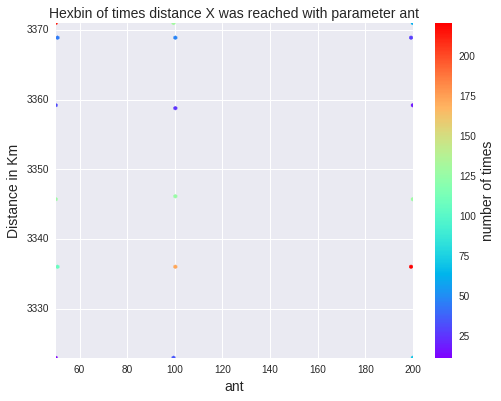

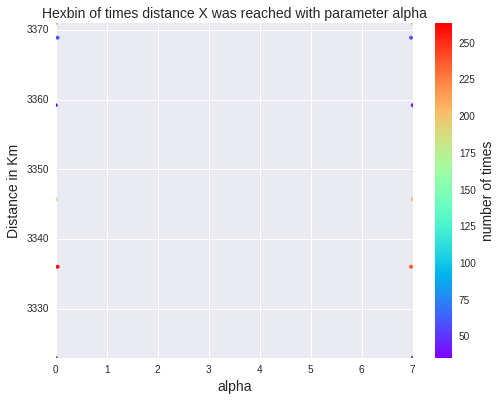

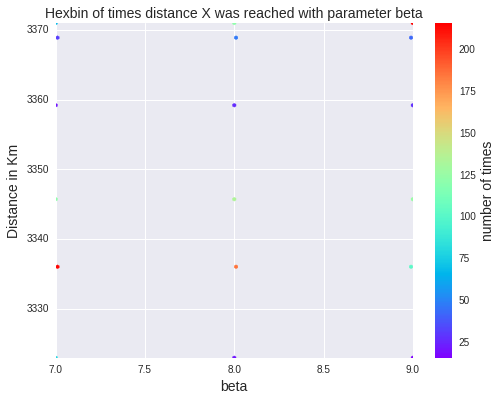

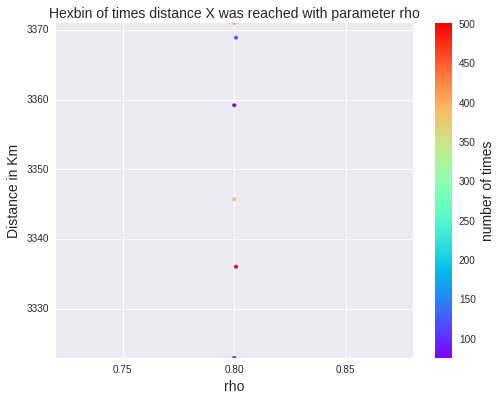

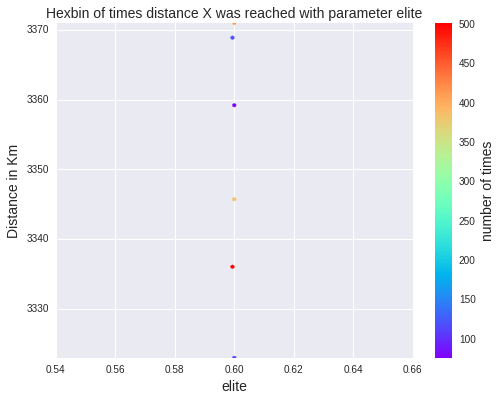

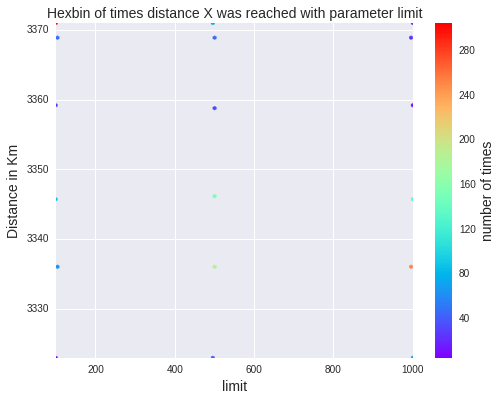

In [80]:
#iterate through each parameter column
for name in clean.columns:
    # since we are interested in the relation between distance and another parameter, those relative columns
    # are excluded from analysis
    if name in ['distance','ID','delta','%delta'] :
        continue
    # create figure
    fig, ax = plt.subplots(figsize=(8,6))
    # create plot type and change setup
    d = ax.hexbin(clean[name],clean['distance'],mincnt=1, cmap=plt.cm.rainbow)
    plt.xlabel(name,fontsize=14)
    plt.ylabel('Distance in Km',fontsize=14)
    plt.title('Hexbin of times distance X was reached with parameter '+name,fontsize=14)
    cb = fig.colorbar(d)
    plt.grid(True)
    cb.set_label('number of times',fontsize=14)
    fig.savefig('burma_initial_img/plot_hexbin_'+name+'.png',dpi=600)
    fig.savefig('burma_initial_img/plot_hexbin_'+name+'.ps',dpi=600)
    fig.savefig('burma_initial_img/plot_hexbin_'+name+'.pdf',dpi=600)

#### Refining

**Repeat hexagrams**

After analizing the result, we can see a lot of good results already, but the final answer is still obscure
since the results are similar to a few values.

To reduce it we are increasing the **minimum** value, this way only after the count reach this minimum we display it

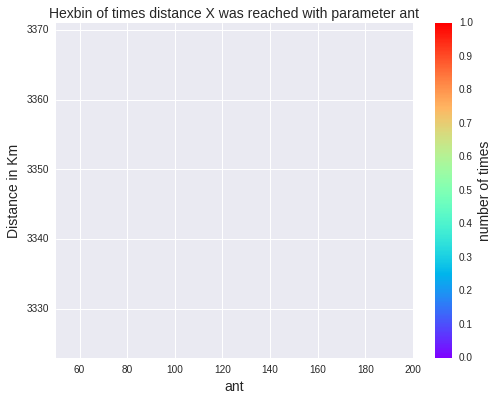

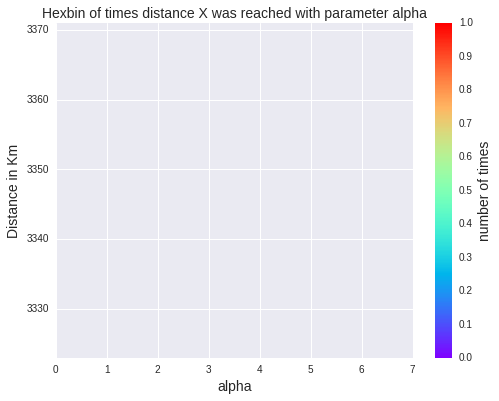

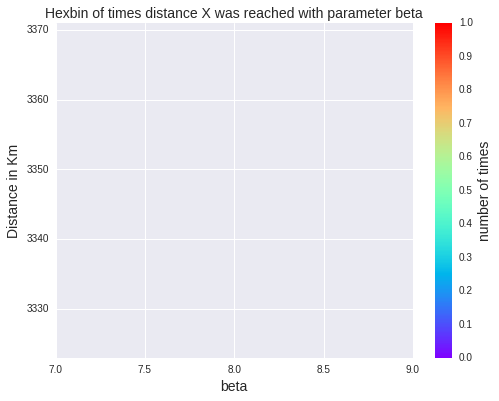

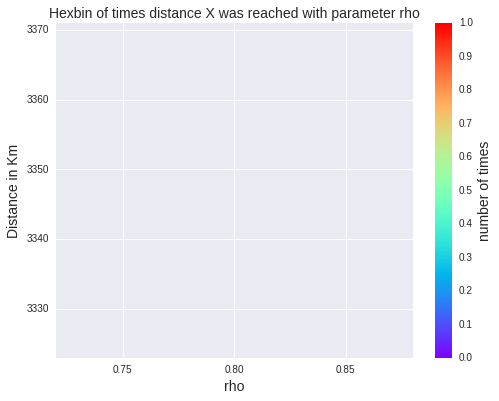

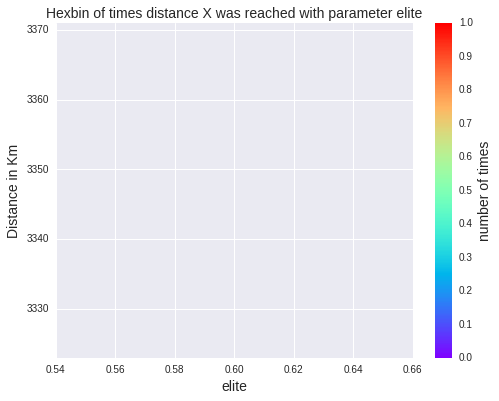

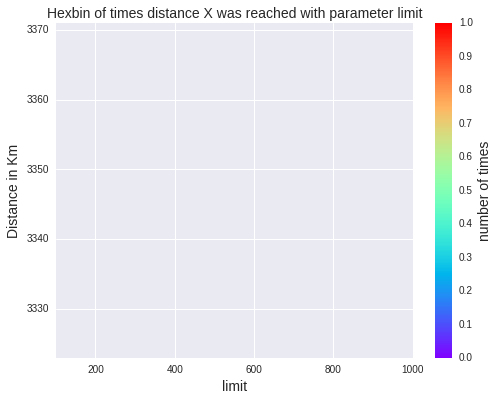

In [81]:
for name in clean.columns:
    if name in ['distance','ID','delta','%delta'] :
        continue
    fig, ax = plt.subplots(figsize=(8,6))
    
    # change point
    # before we only plotted the hexagram, without tuning
    # this time we set the minimal count parameter, so we only display values after it
    # we set it different based on the results
    if name == 'alpha':
        d = ax.hexbin(clean[name],clean['distance'],mincnt=8000, cmap=plt.cm.rainbow)
    elif name == 'rho':
        d = ax.hexbin(clean[name],clean['distance'],mincnt=22000, cmap=plt.cm.rainbow)
    elif name == 'limit':
        d = ax.hexbin(clean[name],clean['distance'],mincnt=28000, cmap=plt.cm.rainbow)
    else:
        d = ax.hexbin(clean[name],clean['distance'],mincnt=18000, cmap=plt.cm.rainbow)
        
    plt.xlabel(name,fontsize=14)
    plt.ylabel('Distance in Km',fontsize=14)
    plt.title('Hexbin of times distance X was reached with parameter '+name,fontsize=14)
    cb = fig.colorbar(d)
    plt.grid(True)
    cb.set_label('number of times',fontsize=14)
    fig.savefig('burma_initial_img/plot_hexbin_refmin_'+name+'.png',dpi=600)
    fig.savefig('burma_initial_img/plot_hexbin_refmin_'+name+'.ps',dpi=600)
    fig.savefig('burma_initial_img/plot_hexbin_refmin_'+name+'.pdf',dpi=600)

#### Analysis


Unfortunatelly the dataset is not uniformilly shapped because of initial try&error tentatives of creating a standalone script to simulate it.

Even so, every case has at least 30 simulations of it, initial cases have a few more.
Because of it, we can say that the points with most repeated solution are the best ones.

From the Graphs would be:

* Ant: 10 ~ 50 (Ant 50 is not fully simulated)
* Alpha: 7
* Beta: 7
* Rho: 0.2, 0.5, 0.8
* Elite: 0.6
* Limit: 100

Next step is to verify this with statistical analysis

### Third Step 
#### Statistical Analysis

The idea in the previous steps were to gain information about this phenomenon, what is happening, is it replicable, when does it happens, how does it happens. Those kind of question were answered, at least in part. Now remains the question, **_why_**?

And now we try to answer it. With some statistical tools we try to gain knowledge about this phenomenon

1) Linear Model 1 variable
Our first try is to see how every parameter answer as a LM, we seek something like

```
y = a*x + b
```
This code show as y as variable dependable of x by a scale of a with an error of b

We are intereted in 3 values: 

- The parameter value it self, in our exemple the value a

- The P-value, it shows the statistical significance of our parameter, in simple words: 'Is my value random?'

- The R^2 value, it shows how much this LM can explain my data

- The Correlation between our parameter and the distance, "if the parameter increase 1 point what happens to the distance?"

In [10]:
# auxiliar array
aux = []
# same trick to ignore ours parameters
for name in clean.columns:
    if name in ['distance','ID','delta','%delta'] :
        continue
    
    # formula for the linear model
    # this notation can be read as 
    # distance is proportional to parameter name
    # we are interested in find this proportion
    formula = "Q('distance') ~ Q('"+name+"')"
    model = smf.ols(formula,data=clean)
    # if the Number of OBServations is lower than ha
    if model.nobs < len(clean)/2:
        continue
        
    results = model.fit()
    
    #insert R^2 values in aux array with the parameter name
    aux.append((results.rsquared, name))
    #The Real Values of the Parameters
    print(results.params)
    #The P-value between 0 and 1, 0 is better
    print(results.pvalues)
    print(' ')
    #Pearson Correlation - Correlation
    print('pearson correlation distance and '+name,clean[name].corr(clean['distance'],method='pearson'))
    
    # Spearman Correlation - Correlation - with more robust approach to non linearity
    print('spearman correlation distance and '+name,clean[name].corr(clean['distance'],method='spearman'))
    print(' ')

    
#rank the array from greatest to lowest
aux.sort(reverse=True)
for mse,name in aux:
    print(name,mse)

Intercept    3791.834879
Q('ant')       -1.667313
dtype: float64
Intercept    0
Q('ant')     0
dtype: float64
 
pearson correlation distance and ant -0.0696178677712
spearman correlation distance and ant -0.0756319559367
 
Intercept     3748.735957
Q('alpha')       1.418546
dtype: float64
Intercept     0.000000e+00
Q('alpha')    5.354695e-09
dtype: float64
 
pearson correlation distance and alpha 0.00702897906978
spearman correlation distance and alpha 0.0160076731764
 
Intercept    4187.154184
Q('beta')    -161.091851
dtype: float64
Intercept    0
Q('beta')    0
dtype: float64
 
pearson correlation distance and beta -0.755883957712
spearman correlation distance and beta -0.856622608888
 
Intercept    3755.411093
Q('rho')       -4.532114
dtype: float64
Intercept    0.000000
Q('rho')     0.094682
dtype: float64
 
pearson correlation distance and rho -0.00201292776724
spearman correlation distance and rho -0.00187708841587
 
Intercept     3754.692416
Q('elite')      -3.708334
dtype: floa

#### _First Analysis_

A first look through this numbers show us that Beta is the most explanatory data, with a _85%_ correlation with the decrease of distance. But our linear model only shows a R^2 of 57%

This may be related to seeing beta as an Linear parameter rather than an Non-Linear and even a Categorical one.

Looking at the graphs may helps us better understand it 

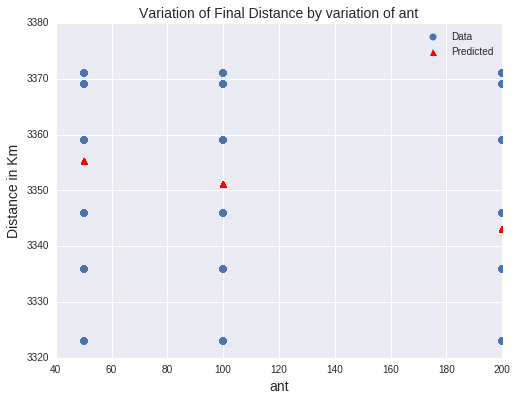

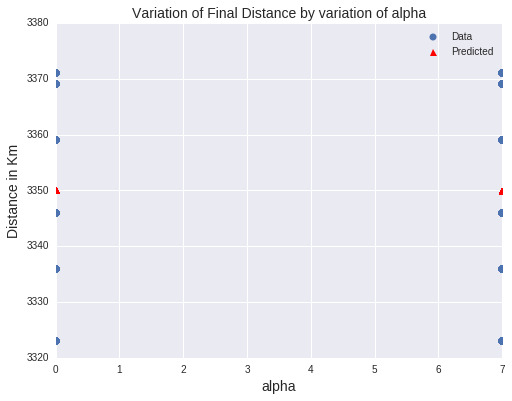

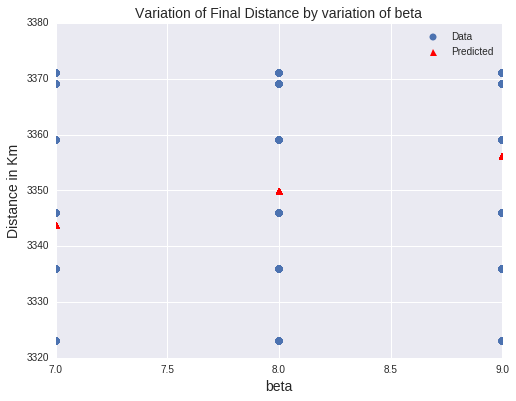

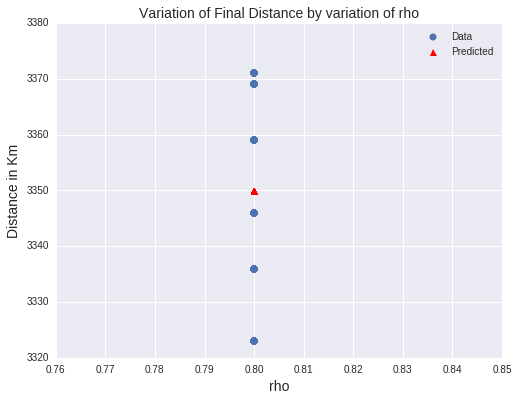

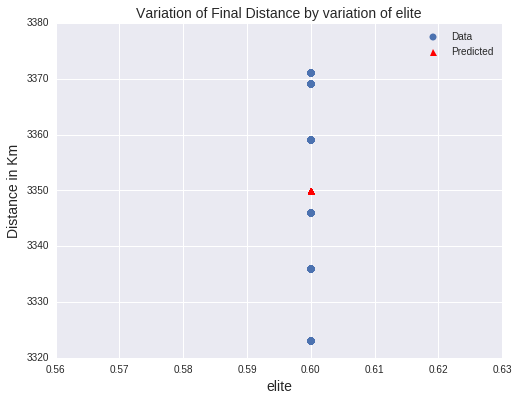

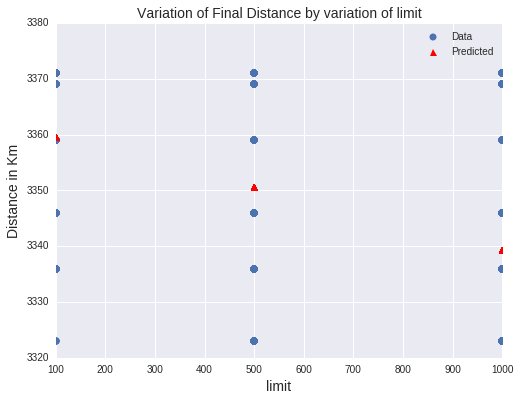

In [82]:
for name in clean.columns:
    if name in ['distance','ID','delta','%delta'] :
        continue

    formula = "Q('distance') ~ Q('"+name+"')"
    model = smf.ols(formula,data=clean)
    if model.nobs < len(clean)/2:
        continue
        
    results = model.fit()

    #ploting a figure with our data points and with the modelled points
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(clean[name], clean['distance'], 'o', label="Data")
    ax.plot(clean[name], results.fittedvalues, '^r', label="Predicted")
    plt.xlabel(name,fontsize=14)
    plt.ylabel('Distance in Km',fontsize=14)
    plt.title('Variation of Final Distance by variation of '+name,fontsize=14)
    plt.grid(True)
    legend = ax.legend(loc="best")
    fig.savefig('burma_initial_img/plot_distance_'+name+'.png',dpi=600)
    fig.savefig('burma_initial_img/plot_distance_'+name+'.ps',dpi=600)
    fig.savefig('burma_initial_img/plot_distance_'+name+'.pdf',dpi=600)

#### Graph Analysis - Linear Model
Both graphs for each parameter are essentially the same. The first one shows the Distance ~ Paramter and the second one %Delta ~ Parameter. The latter says about how much extra distance from the optimal this parameter create, or how close to optimal does it get?


We can see that because of the way this simulations were designed. With the Economics idea of Ceteris Paribus in mind, each simulation only changes one value and sees how the whole system reacts to it. This way even with a non-linear moviment as the Beta parameter, we should still treaty each possible value as category with a binary way, either on or off.

So in our refing step we change from LM to Categorical Binary Model.

In [13]:
# auxiliar array
aux = []
corr_spearman = {}
corr_pearson = {}
# same trick to ignore ours parameters
for name in clean.columns:
    if name in ['distance','ID','delta','%delta'] :
        continue
    
    # formula for the linear model
    # this notation can be read as 
    # distance is proportional to parameter name
    # we are interested in find this proportion
    formula = "Q('distance') ~ C(Q('"+name+"'))-1"
    model = smf.ols(formula,data=clean)
    # if the Number of OBServations is lower than ha
    if model.nobs < len(clean)/2:
        continue
        
    results = model.fit()
    
    #insert R^2 values in aux array with the parameter name
    aux.append((results.rsquared, name))
    #The Real Values of the Parameters
    print(results.params)
    #The P-value between 0 and 1, 0 is better
    print(results.pvalues)
    print(' ')
    #Pearson Correlation - Correlation
    corr_pearson[name] = clean[name].corr(clean['distance'],method='pearson')
    
    # Spearman Correlation - Correlation - with more robust approach to non linearity
    corr_spearman[name] = clean[name].corr(clean['distance'],method='spearman')
    

    
#rank the array from greatest to lowest
aux.sort(reverse=True)
for mse,name in aux:
    print(name,mse,corr_pearson[name],corr_spearman[name])

C(Q('ant'))[10]    3775.161748
C(Q('ant'))[50]    3708.469222
dtype: float64
C(Q('ant'))[10]    0
C(Q('ant'))[50]    0
dtype: float64
 
C(Q('alpha'))[0.0]     3768.049448
C(Q('alpha'))[0.25]    3787.121976
C(Q('alpha'))[0.5]     3735.931827
C(Q('alpha'))[0.75]    3734.352395
C(Q('alpha'))[1.0]     3734.865185
C(Q('alpha'))[1.5]     3735.579728
C(Q('alpha'))[2.0]     3734.860074
C(Q('alpha'))[2.5]     3734.621704
C(Q('alpha'))[3.0]     3734.561358
C(Q('alpha'))[3.5]     3733.904247
C(Q('alpha'))[4.0]     3734.611728
C(Q('alpha'))[4.5]     3820.273508
C(Q('alpha'))[5.0]     3768.481889
C(Q('alpha'))[6.0]     3780.210193
C(Q('alpha'))[7.0]     3723.000252
dtype: float64
C(Q('alpha'))[0.0]     0
C(Q('alpha'))[0.25]    0
C(Q('alpha'))[0.5]     0
C(Q('alpha'))[0.75]    0
C(Q('alpha'))[1.0]     0
C(Q('alpha'))[1.5]     0
C(Q('alpha'))[2.0]     0
C(Q('alpha'))[2.5]     0
C(Q('alpha'))[3.0]     0
C(Q('alpha'))[3.5]     0
C(Q('alpha'))[4.0]     0
C(Q('alpha'))[4.5]     0
C(Q('alpha'))[5.0]     0

#### Graph Analysis - Categorical Model
Now our results starts to improve, even values with statistical insignificance, given from high P-values, are better indicating their differences and also sorting which is the best of them.

Our R^2 is closer to our correlation now. This confirms that this Model better explain what our simulations intended to show, which parameter changes more our result, and from a preset of values which gives better performance.

From our Analysis until now they are:

1. Beta
2. Limit
3. Ant
4. Alpha
5. Elite - not significant
6. Rho - not significant

Our next step is to combine Beta and this other results to see what that bringes

PatsyError: Error converting data to categorical: observation with value 10 does not match any of the expected levels (expected: [50.0, 100.0, 200.0])
    Q('distance') ~ C(Q('beta')) + C(Q('ant')) -1
                                   ^^^^^^^^^^^

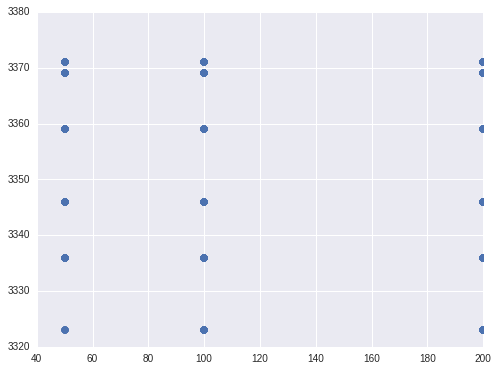

In [83]:
#Generating arrays for tuples of data
betas = np.array((0,0.25,0.5,0.75,1,1.5,2,2.5,3,3.5,4,4.5,5,6,7))
alphas = np.array((0,0.25,0.5,0.75,1,1.5,2,2.5,3,3.5,4,4.5,5,6,7))
ants = np.array((10,50))
limits = np.array((10,100))
rhos = np.array((0.2,0.4,0.5,0.6,0.8))
elites = np.array((0,0.2,0.4,0.5,0.6,0.8))

alpha = [(beta,i) for beta in betas for i in alphas]
ant = [(beta,i) for beta in betas for i in ants]
limit = [(beta,i) for beta in betas for i in limits]
rho = [(beta,i) for beta in betas for i in rhos]
elite = [(beta,i) for beta in betas for i in elites]



#Dict of tuples with the parameters values
dfs = {'alpha':alpha,'ant':ant,'limit':limit,'rho':rho,'elite':elite}

#skip trick
for name in clean.columns:
    if name in ['distance','ID','beta','delta','%delta'] :
        continue
    
    #formula for Two Categories
    formula = "Q('distance') ~ C(Q('beta')) + C(Q('"+name+"')) -1"
    model = smf.ols(formula,data=clean)     
    results = model.fit()
    
    #plot data
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(clean[name], clean['distance'], 'o', label="Data")
    #generate a data frame from the tuples
    df = pd.DataFrame(dfs[name], columns=['beta',name])
    #separate the different Betas so two show with diffrent colors
    for i in betas:
        x = df.loc[df.loc[:,'beta']==i]
        ax.plot(x[name],results.predict(x) , '^-', label="Predicted beta "+str(i))
    plt.xlabel(name,fontsize=14)
    plt.ylabel('Distance in Km',fontsize=14)
    plt.title('Variation of  Distance by variation of '+name+'with Beta separation',fontsize=14)
    plt.grid(True)
    legend = ax.legend(loc="upper right",bbox_to_anchor=(1.35, 1.0))
    fig.savefig('burma_initial_img/plot_'+name+'_beta.png',dpi=600)
    fig.savefig('burma_initial_img/plot_'+name+'_beta.ps',dpi=600)
    fig.savefig('burma_initial_img/plot_'+name+'_beta.pdf',dpi=600)

#### Graph Analysis - Two Categories Model

Confirmation! So, the graphs confirm what we already knew. A higher Beta leads to a lower Distance, in all case-scenarios. This confirms the Spearman and Pearson correlation showing that beta alone explain most of the model.
So we shall pick Beta 7. 
These graph also show that Rho and Elite have now real change between different cases. This way, there is no real picking, from this analysis alone.

Alpha in the other hand shows two moments of slight increases in 0 to 0.25 and 4 to 4.5, and no indication of decrease. So alpha 0 is the best result.

In contrast, Ant and Limit have great descent in the cases studied. Both of them shows that higher values lead to lower distance. From our cases, Ant 50 and Limit 100 are the choosen ones.

Remembering:

* Alpha: 0
* Beta: 7 (Higher)
* Rho: Anyone
* Elite: Anyone
* Ant: 50 (Higher)
* Limit: 100 (Higher)

#### Multi Category Model Analysis

One last is to test to do is a stacked test. Change one item at a time we going to construct Seven Models and see how including that item change the previous model or the base model.

As result from this we can see how each value possible for the parameters affects our Model

In [23]:
#Seven Model based on all values possible for each category without an intercept
formula1 = 'distance ~ C(beta)-1'
formula2 = 'distance ~ C(beta)+C(ant)-1'
formula3 = 'distance ~ C(beta)+C(limit)-1'
formula4 = 'distance ~ C(beta)+C(limit)+C(ant)-1'
formula5 = 'distance ~ C(beta)+C(limit)+C(ant)+C(alpha)-1'
formula6 = 'distance ~ C(beta)+C(limit)+C(ant)+C(rho)-1'
formula7 = 'distance ~ C(beta)+C(limit)+C(ant)+C(elite)-1'

formulas = [formula1,formula2,formula3,formula4,formula5,formula6,formula7]
t = []
models = {}

for formula in formulas:
    model = smf.ols(formula,data=clean)
    results = model.fit()
        
    t.append((results.rsquared, formula))
    
t.sort(reverse=True)
for mse,formula in t:
    #difference between this model and the Base model
    diff = mse - t[6][0]

    print(formula,mse*100,diff*100)

distance ~ C(beta)+C(limit)+C(ant)+C(alpha)-1 89.0318256093 6.11050905795
distance ~ C(beta)+C(limit)+C(ant)+C(elite)-1 89.0175376338 6.09622108246
distance ~ C(beta)+C(limit)+C(ant)+C(rho)-1 89.0172888588 6.09597230752
distance ~ C(beta)+C(limit)+C(ant)-1 89.0172646967 6.09594814544
distance ~ C(beta)+C(limit)-1 86.1505710345 3.22925448318
distance ~ C(beta)+C(ant)-1 83.9886859166 1.06736936535
distance ~ C(beta)-1 82.9213165513 0.0


#### _Categories Analysis_

Our latest test shows that Parameter Beta explain most of the Model, but Ant and Limit also contribute signifcantly. In opposite direction, Rho, Limit and Alpha impact very little with an explanation of 0,014% more than the other had already explained.

The values shown for the parameters are also in the way we expected, except for _alpha_. Even with low influence in the overall Model, the formula result indicates that Alpha 6 as the resposible for most impact in lowering the distance. But, the values in Alpha all overlap and this value can be an result from it.

### Conjugate Analysis and going Further

Both our analysis shows similarities in Beta and Limit. The Parameter Ant tends to higher values, but no concrete answer since it was not fully simulated by the end of this notebook with the repeated process, but least stick with this idea.

There were also some differences. Alpha in the stats should be 0, but there were more lower values in with alpha 7. Rho and Elite also have preferentiable values with the repeated process, but stats say there is no significance in them, so anyone is a good choice.



## Going Further - a new simulation

To sort this problems out, I ran a new simulation with values:

* Limit: 100, 500, 1000
* Ant: 50, 100, 200
* Alpha: 0, 4.5, 7
* Beta: 7, 8, 9
* Rho: 0.8
* Elite: 0.6

This new simulation is going to test the differences we found and our new beliefs:

- Which Alpha is the best?
- The Higher value for Limit, Ant and Beta are really better?

### First Steps
#### Initializing the Dataset

In [49]:
#importing needed libraries
# DataFrame library
import pandas as pd
# numerical library
import numpy as np
# Scientifical library
import scipy as sp
# Statistical Library with R notation for Linear Models
import statsmodels.formula.api as smf
# Ploting Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Creating the pandas DataFrame from csv file
df = pd.read_csv("burma14beyond.csv")
#cleaning cells with Not Available data, or erased cell
clean = df.dropna()
clean.describe()

rm = pd.read_csv("restrainedModel.csv")
rm.loc[rm['time']<0,'time'] = pd.np.nan
rm.fillna(value=rm.mean(),inplace=True)
om = pd.read_csv("optimalModel.csv")
om.loc[om['time']<0,'time'] = pd.np.nan
om.fillna(value=om.mean(),inplace=True)

,distance,time
0,3336,217.647376
1,3336,217.811305
2,3336,215.822101
3,3323,214.249943
4,3336,218.329663
5,3336,206.282223
6,3323,210.755373
7,3336,203.623736
8,3336,202.054885
9,3336,215.679615


In [50]:
rm.describe()

,distance,time
count,1000.000000,1000.000000
mean,3346.841000,25.637213
std,14.058071,5.042543
min,3323.000000,7.617459
25%,3336.000000,23.305068
50%,3346.000000,24.139958
75%,3359.000000,28.054229
max,3371.000000,39.192649


In [78]:
print((rm.quantile(0).distance/3323-1)*100)
print((rm.quantile(0.25).distance/3323-1)*100)
print((rm.quantile(0.5).distance/3323-1)*100)
print((rm.quantile(0.75).distance/3323-1)*100)
print((rm.quantile(1).distance/3323-1)*100)

0.0
0.391212759555
0.69214565152
1.08335841107
1.44447788143


In [79]:
print((om.quantile(0).distance/3323-1)*100)
print((om.quantile(0.25).distance/3323-1)*100)
print((om.quantile(0.5).distance/3323-1)*100)
print((om.quantile(0.75).distance/3323-1)*100)
print((om.quantile(1).distance/3323-1)*100)

0.0
0.0
0.391212759555
0.391212759555
0.69214565152


In [73]:
om.describe()

,distance,time
count,1000.000000,1000.000000
mean,3330.594000,208.780807
std,6.777101,22.524447
min,3323.000000,163.000266
25%,3323.000000,197.965342
50%,3336.000000,207.514951
75%,3336.000000,213.346053
max,3346.000000,482.074106


####  Create Hexagram

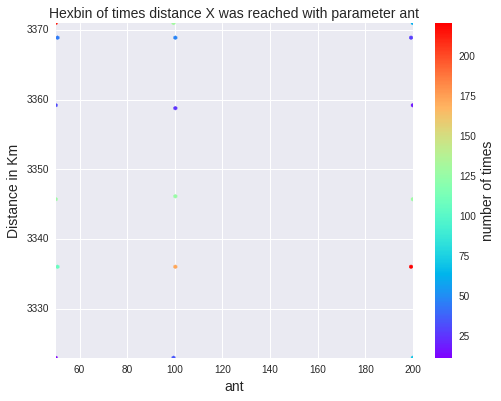

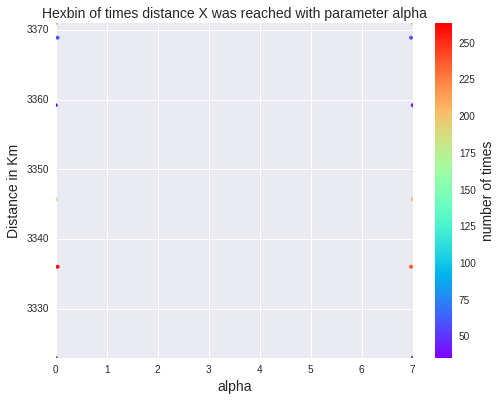

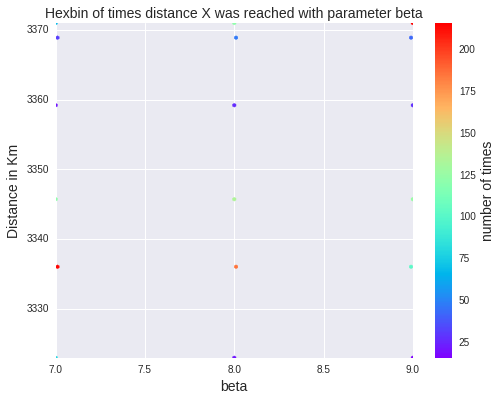

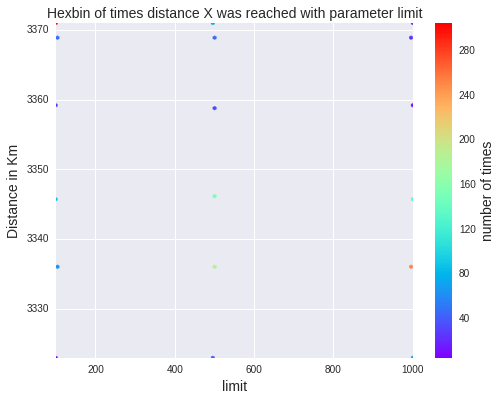

In [4]:
#iterate through each parameter column
for name in clean.columns:
    # since we are interested in the relation between distance and another parameter, those relative columns
    # are excluded from analysis
    if name in ['distance','ID','delta','%delta','rho','elite'] :
        continue
    # create figure
    fig, ax = plt.subplots(figsize=(8,6))
    # create plot type and change setup
    d = ax.hexbin(clean[name],clean['distance'],mincnt=1, cmap=plt.cm.rainbow)
    plt.xlabel(name,fontsize=14)
    plt.ylabel('Distance in Km',fontsize=14)
    plt.title('Hexbin of times distance X was reached with parameter '+name,fontsize=14)
    cb = fig.colorbar(d)
    cb.set_label('number of times',fontsize=14)
    fig.savefig('burma_further_img/plot_hexbin_'+name+'.png',dpi=600)
    fig.savefig('burma_further_img/plot_hexbin_'+name+'.pdf',dpi=600)
    fig.savefig('burma_further_img/plot_hexbin_'+name+'.ps',dpi=600)

#### One Category Model

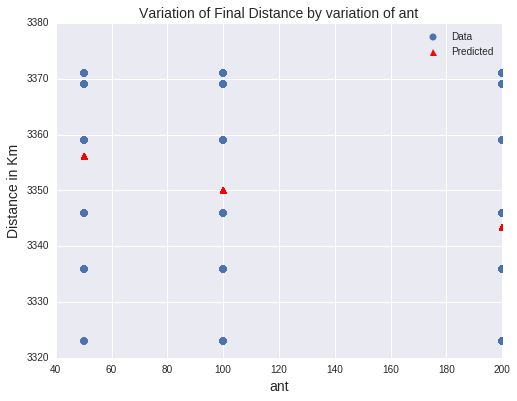

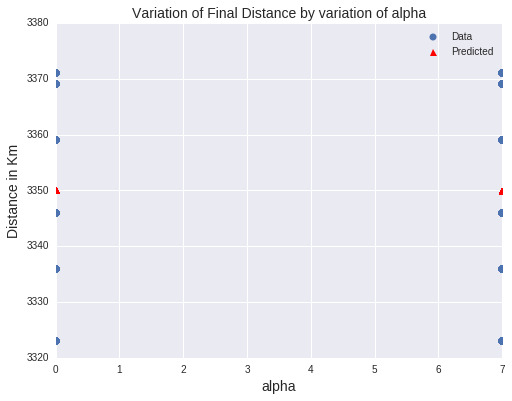

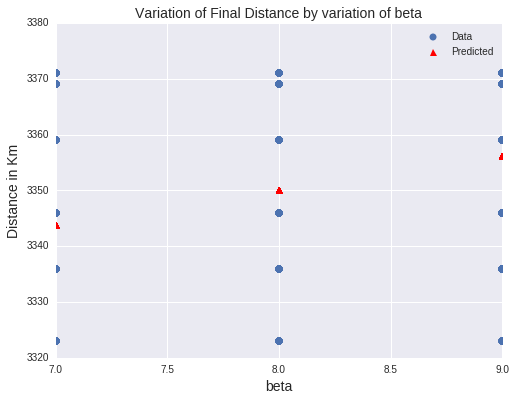

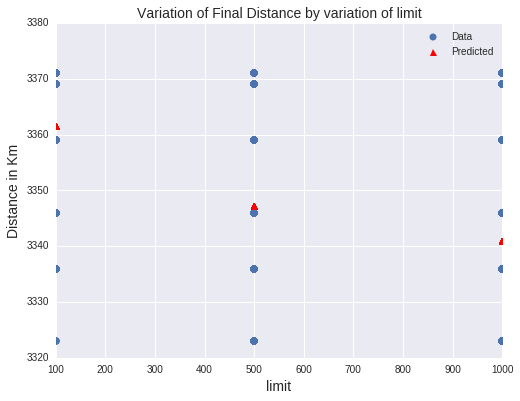

In [5]:
for name in clean.columns:
    if name in ['distance','ID','delta','%delta','rho','elite'] :
        continue

    formula = "Q('distance') ~ C(Q('"+name+"'))"
    model = smf.ols(formula,data=clean)
    if model.nobs < len(clean)/2:
        continue
        
    results = model.fit()

    #ploting a figure with our data points and with the modelled points
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(clean[name], clean['distance'], 'o', label="Data")
    ax.plot(clean[name], results.fittedvalues, '^r', label="Predicted")
    plt.xlabel(name,fontsize=14)
    plt.ylabel('Distance in Km',fontsize=14)
    plt.title('Variation of Final Distance by variation of '+name,fontsize=14)
    plt.grid(True)
    legend = ax.legend(loc="best")
    fig.savefig('burma_further_img/plot_distance_'+name+'.png',dpi=600)
    fig.savefig('burma_further_img/plot_distance_'+name+'.pdf',dpi=600)
    fig.savefig('burma_further_img/plot_distance_'+name+'.ps',dpi=600)

#### Two Categories Model

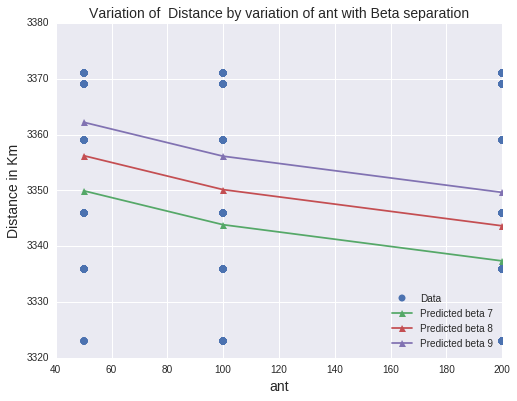

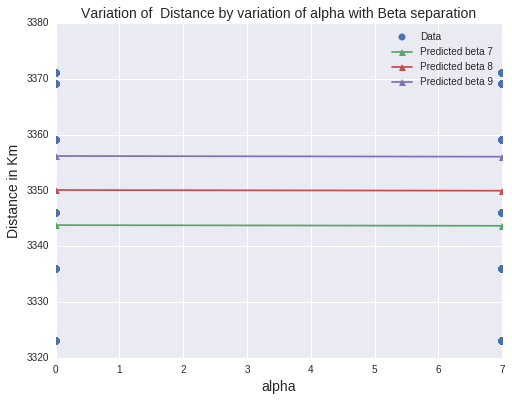

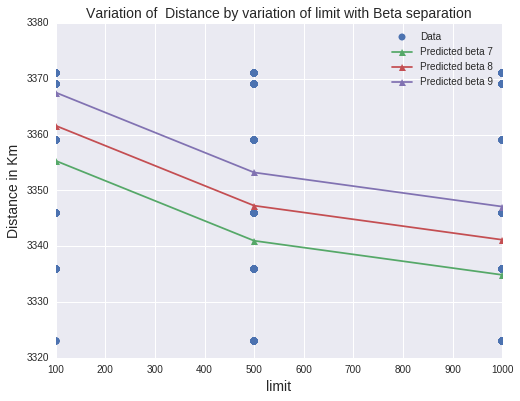

In [8]:
#Generating arrays for tuples of data
betas = np.array((7,8,9))
alphas = np.array((0,7))
ants = np.array((50,100,200))
limits = np.array((100,500,1000))

alpha = [(beta,i) for beta in betas for i in alphas]
ant = [(beta,i) for beta in betas for i in ants]
limit = [(beta,i) for beta in betas for i in limits]



#Dict of tuples with the parameters values
dfs = {'alpha':alpha,'ant':ant,'limit':limit}

#skip trick
for name in clean.columns:
    if name in ['distance','ID','beta','delta','%delta','rho','elite'] :
        continue
    
    #formula for Two Categories
    formula = "Q('distance') ~ C(Q('beta')) + C(Q('"+name+"')) -1"
    model = smf.ols(formula,data=clean)     
    results = model.fit()
    
    #plot data
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(clean[name], clean['distance'], 'o', label="Data")
    #generate a data frame from the tuples
    df = pd.DataFrame(dfs[name], columns=['beta',name])
    #separate the different Betas so two show with diffrent colors
    for i in betas:
        x = df.loc[df.loc[:,'beta']==i]
        ax.plot(x[name],results.predict(x) , '^-', label="Predicted beta "+str(i))
    plt.xlabel(name,fontsize=14)
    plt.ylabel('Distance in Km',fontsize=14)
    plt.title('Variation of  Distance by variation of '+name+' with Beta separation',fontsize=14)
    plt.grid(True)
    #legend = ax.legend(loc="upper right",bbox_to_anchor=(1.3, 1.0))
    legend = ax.legend(loc="best")
    fig.savefig('burma_further_img/plot_beta_'+name+'.png',dpi=600)
    fig.savefig('burma_further_img/plot_beta_'+name+'.pdf',dpi=600)
    fig.savefig('burma_further_img/plot_beta_'+name+'.ps',dpi=600)

## Final Answer

In [7]:
formula = 'distance ~ C(beta)+C(limit)+C(ant)+C(alpha)-1'

model = smf.ols(formula,data=clean)
results = model.fit()

print(results.summary())

formula = 'distance ~ C(beta)+C(limit)+C(ant)-1'

model = smf.ols(formula,data=clean)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     212.5
Date:                Mon, 22 Feb 2016   Prob (F-statistic):          2.87e-223
Time:                        02:31:55   Log-Likelihood:                -6240.6
No. Observations:                1611   AIC:                         1.250e+04
Df Residuals:                    1603   BIC:                         1.254e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
C(beta)[7.0]        3361.7652      0

#### Discussion

The Final solution is not entirelly unexepected. The meaning of the parameters to this kind of Problem inform us that closeness and more space covering are the key in finding the optimal solution.

Beta leads to closer solution, Ant and Limit lead to more space covering, allowing our system to find the global optimum.

Alpha, Rho and Elite are random influences, and while may help, they remain random not really influencing too much the final answer.

All this results, while true, may only be true to this set of data. There is need to run this same analysis on other datasets with different sizes, so it be through also to bigger graphs, and different graphs of similar size, so it not be true only to this peculiar construction.